## Домашнее задание №6

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов соседей по любому из показанных на уроке принципов.

In [100]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris, make_blobs
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import ListedColormap

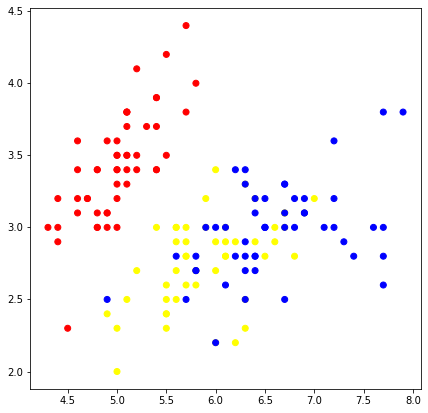

In [101]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

cmap = ListedColormap(['red', 'yellow', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [102]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance), 1/np.sqrt(distance) if distance != 0 else 1

Вычисление веса объекта обучающей выборки

$$w(d) = q^{d}, q \in (0,1)$$

In [103]:
def weight(d, q):
    return q**d

In [104]:
def knn(x_train, y_train, x_test, k, q=0.5):
    
    answers = []
    for x in x_test:
        test_distances = []
        #print(len(answers))    
        for i in range(len(x_train)):
            
            # расчет веса от классифицируемого объекта до
            # объекта обучающей выборки
            d, _ = e_metrics(x, x_train[i])
       
            # Записываем в список значение весы на объекте обучающей выборки
            test_distances.append((weight(d, q), y_train[i]))
            
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список по убыванию (0 < q < 1) и среди первых k элементов считаем частоту появления разных классов
        for d in sorted(test_distances, reverse=True)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [105]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [106]:
k =30

y_pred = knn(X_train, y_train, X_train, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_train):.3f}')

Точность алгоритма при k = 30: 0.783


In [107]:
k = 28

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 28: 0.800


In [108]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .2

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

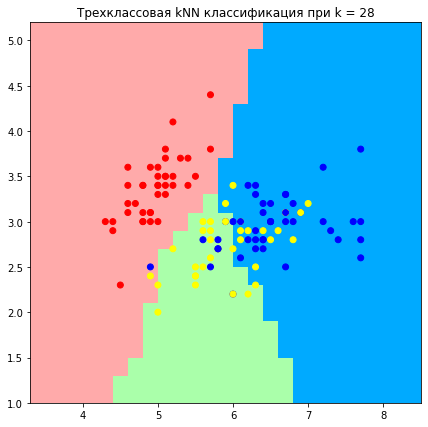

In [109]:
# по уроку как у нас вышло
get_graph(X_train, y_train, k)

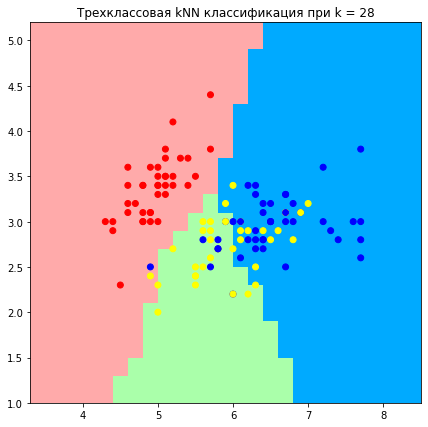

In [110]:
# что вышло с использованием весов
get_graph(X_train, y_train, k)

2. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от k (взять от 1 до 10) для выборки данных из данного урока.

In [111]:
X, y = make_blobs(n_samples=200, centers = 3, random_state=13)

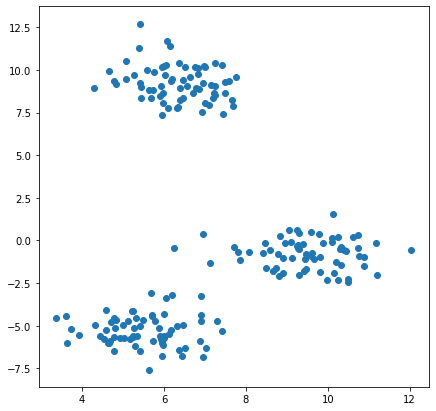

In [112]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

In [113]:
def kmeans(data, k, max_iterations, min_distance):    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # Создадим словарь для классификации
        classes = {i: [] for i in range(k)}
        
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [114]:
def kmeans_quality(centroids, clusters):
    k = 0
    n = 0
    quality = 0
    for c in centroids:
        for x in clusters[k]:
            n += 1
            quality += e_metrics(x, c)[0]
        k+=1
    return quality / n

In [123]:
max_iterations = 10
min_distance = 1e-4
k_list = np.arange(1, 11)

In [124]:
kmeans_q = []
for k in k_list:
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    kmeans_q.append(kmeans_quality(centroids, clusters))

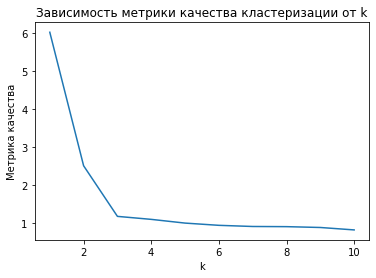

In [125]:
plt.plot(k_list, kmeans_q)
plt.title('Зависимость метрики качества кластеризации от k')
plt.xlabel('k')
plt.ylabel('Метрика качества')
plt.show()

Согласно "принципу локтя" следует выбрать k равным 3. Визуализируем кластеры при k равном 2, 3 и 4, чтобы визуально убедиться в обоснованности такого выбора.

In [126]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b','m','y']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
    plt.grid(True)        
    plt.show()

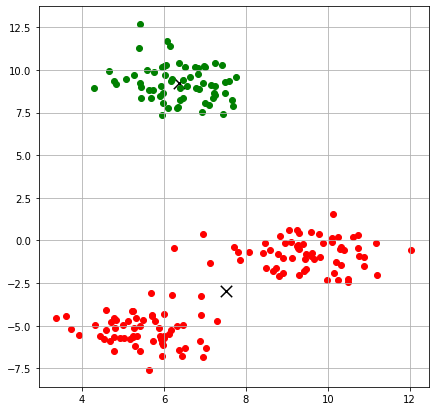

In [127]:
k = 2

centroids, clusters = kmeans(X[10:,:], k, max_iterations, min_distance)

visualize(centroids, clusters)

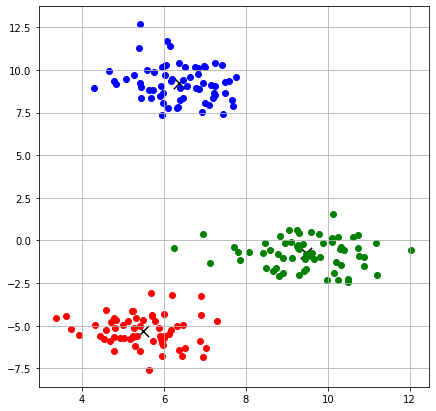

In [128]:
k = 3

centroids, clusters = kmeans(X[10:,:], k, max_iterations, min_distance)

visualize(centroids, clusters)

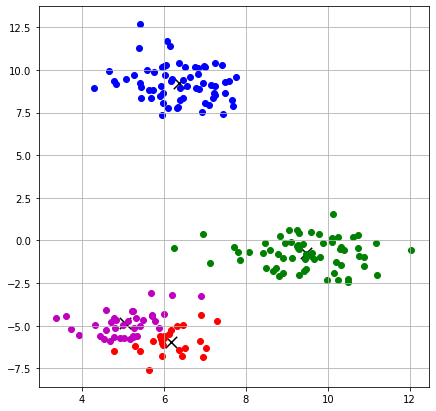

In [129]:
k = 4

centroids, clusters = kmeans(X[10:,:], k, max_iterations, min_distance)

visualize(centroids, clusters)